https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md # medium model, including word vectors (word embeddings) 
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from operator import itemgetter


In [2]:
# DF
df = pd.read_csv("C:\\Users\\Katharina\\Documents\\Uni\\6_WS2223\\Masterarbeit\\code\\WomenInEP\\data\\csv\\debates_meps_combined.csv", index_col=0)
# Show dataframe
df.head()

,int_id,debate_id,speaker,is_mep,text,speaker_id,role,party,text_translated,language,full Name,country,EU political group,national political group,nationalty,gender,birth_year,birth_place,political_groups,national_parties
0,2-008-000,20140701.EN,Presidente,True,Ringrazio il maestro e tutta l'orchestra. Ric...,4436,NaN,NaN,I thank the master and the whole orchestra.I r...,it,NaN,NaN,NaN,NaN,Italy,M,1958,Lauria (PZ),20-07-1999 / 19-07-2004 : Group of the Party o...,20-07-1999 / 19-07-2004 : Democratici di Sinis...
1,2-009-000,20140701.EN,Pablo Iglesias Turrión,True,"Señor Presidente, es un honor dirigirme a ust...",125031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,M,1978,Madrid,01-07-2014 / 27-10-2015 : Confederal Group of ...,01-07-2014 / 27-10-2015 : PODEMOS (Spain)
2,2-010-000,20140701.EN,Sajjad Karim,True,"Mr President, I rise to speak with a sense of...",28481,NaN,NaN,"Mr President, I rise to speak with a sense of ...",en,NaN,NaN,NaN,NaN,United Kingdom,M,1970,Lancashire,20-07-2004 / 11-12-2007 : Group of the Allianc...,20-07-2004 / 13-07-2009 : UK Independence Part...
3,2-011-000,20140701.EN,Ulrike Lunacek,True,"Mr President, firstly let me welcome all the ...",97017,NaN,NaN,"Mr President, firstly let me welcome all the n...",en,NaN,NaN,NaN,NaN,Austria,F,1957,Krems a.d. Donau,14-07-2009 / 04-02-2013 : Group of the Greens/...,14-07-2009 / 30-06-2014 : Die Grünen - Die Grü...
4,2-013-000,20140701.EN,Martin Schulz,True,"Herr Präsident, meine sehr geehrten Damen und...",1911,NaN,NaN,"Mr. President, my dear ladies and gentlemen, d...",de,NaN,NaN,NaN,NaN,Germany,M,1955,Hehlrath,19-07-1994 / 19-07-1999 : Group of the Party o...,19-07-1994 / 19-07-1999 : Sozialdemokratische ...


In [3]:
df_original = df # as a backup

## 'DF' changed: excluding NaN's of 'language': 268591 (97,6%)

In [4]:
#df = df_original #only use to reset 'df'
df = df.loc[~df['language'].isna()]

In [5]:
df = df.iloc[:,:9]
df = df.drop('is_mep', axis=1)
df = df.drop('role', axis=1)
df = df.drop('party', axis=1)
df

,int_id,debate_id,speaker,text,speaker_id,text_translated
0,2-008-000,20140701.EN,Presidente,Ringrazio il maestro e tutta l'orchestra. Ric...,4436,I thank the master and the whole orchestra.I r...
2,2-010-000,20140701.EN,Sajjad Karim,"Mr President, I rise to speak with a sense of...",28481,"Mr President, I rise to speak with a sense of ..."
3,2-011-000,20140701.EN,Ulrike Lunacek,"Mr President, firstly let me welcome all the ...",97017,"Mr President, firstly let me welcome all the n..."
4,2-013-000,20140701.EN,Martin Schulz,"Herr Präsident, meine sehr geehrten Damen und...",1911,"Mr. President, my dear ladies and gentlemen, d..."
5,2-014-000,20140701.EN,Beatrix von Storch,Herr Präsident! Mein Name ist Beatrix von Sto...,124825,Mister President!My name is Beatrix von Storch...
...,...,...,...,...,...,...
275091,3-368-0000,20220216.EN,Ciarán Cuffe,"A Uachtarán, I dtús báire, bhí an togra Eurov...",197654,"His president, initially, was the Eurovignette..."
275092,3-369-0000,20220216.EN,Sēdes vadītājs,"Liels paldies! Un tiešām gandarījums, ka Eiro...",28615,"Thank you very much!And indeed, the European U..."
275093,3-370-0000,20220216.EN,Helena Dalli,"Mr President, it’s good to hear that many of ...",photo_generic,"Mr President, it’s good to hear that many of y..."
275094,3-371-0000,20220216.EN,Sēdes vadītājs,"Debates ir beigušās par šo tematu, un es grib...",28615,"The debate has ended on this topic, and I want..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268591 entries, 0 to 275095
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   int_id           268591 non-null  object
 1   debate_id        268591 non-null  object
 2   speaker          265298 non-null  object
 3   text             268591 non-null  object
 4   speaker_id       268591 non-null  object
 5   text_translated  268591 non-null  object
dtypes: object(6)
memory usage: 14.3+ MB


#### subset of top 100.000 rows

In [7]:
df_subset = df.head(100000)

### topic modeling

In [8]:
# Our spaCy model:
# English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
nlp = en_core_web_md.load()

# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

tokens = []
for text in nlp.pipe(df['text_translated']):
   proj_tok = [token.lemma_.lower() for token in text if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [9]:
#nlp.analyze_pipes()

In [10]:
df['tokens'] = tokens
df['tokens']

0         [thank, master, orchestra, remember, pursuant,...
2         [mr, president, rise, speak, sense, duty, arri...
3         [mr, president, let, welcome, elect, elect, me...
4         [president, dear, lady, gentleman, dear, uniqu...
5         [mister, beatrix, von, storch, alternative, ge...
                                ...                        
275091    [president, eurovignette, proposal, promise, e...
275092    [thank, european, union, different, language, ...
275093    [mr, president, good, hear, favour, agreement,...
275094    [debate, end, topic, want, remind, colleague, ...
275095    [meeting, resume, tomorrow, thursday, february...
Name: tokens, Length: 268591, dtype: object

In [11]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df['tokens'])

In [12]:
dictionary.token2id

{'able': 0,
 'absolute': 1,
 'accept': 2,
 'accordance': 3,
 'act': 4,
 'add': 5,
 'agenda': 6,
 'alphabetical': 7,
 'application': 8,
 'article': 9,
 'ballot': 10,
 'body': 11,
 'candidate': 12,
 'card': 13,
 'change': 14,
 'citizen': 15,
 'clear': 16,
 'close': 17,
 'colleague': 18,
 'commission': 19,
 'competent': 20,
 'concern': 21,
 'condition': 22,
 'consent': 23,
 'consideration': 24,
 'contribute': 25,
 'count': 26,
 'counter': 27,
 'decide': 28,
 'declaration': 29,
 'deputy': 30,
 'direct': 31,
 'discussion': 32,
 'dispute': 33,
 'distribute': 34,
 'document': 35,
 'elect': 36,
 'election': 37,
 'enjoy': 38,
 'entry': 39,
 'equitable': 40,
 'establish': 41,
 'europe': 42,
 'european': 43,
 'exercise': 44,
 'expectation': 45,
 'express': 46,
 'extraneous': 47,
 'floor': 48,
 'follow': 49,
 'friend': 50,
 'function': 51,
 'great': 52,
 'group': 53,
 'having': 54,
 'hemicycle': 55,
 'honor': 56,
 'honorable': 57,
 'hope': 58,
 'iglesias': 59,
 'incompatibility': 60,
 'incompatibl

In [13]:
# below = appearance in less than 5 documents, above = in more than 50% of all documents; keep n= keep 1000 most frequent tokens after filtering
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [14]:
# occurance of words per document(row of df)
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

In [15]:
corpus

[[(0, 1),
  (1, 1),
  (2, 3),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 6),
  (8, 1),
  (9, 5),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 2),
  (23, 7),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 6),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 3),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 2),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 7),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 3),
  (65, 2),
  (66, 6),
  (67, 2),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 6),
  (72, 2),
  (73, 2),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 5),
  (82, 1),
  (83, 1),
  (84, 2),
  (85, 1)],
 [(1, 1),
  (11, 2),
  (15, 2),
  (27, 1),
  (28, 3),
  (31, 4)

In [19]:
# Latent Dirichlet Allocation
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 2, passes=10)

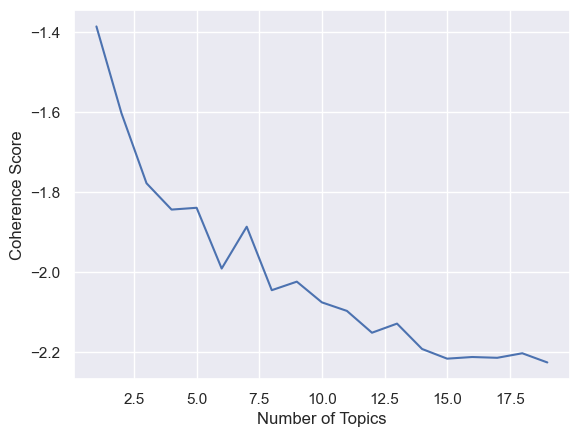

In [20]:
#Calculating the coherence score using C_umass:
topics = []
score = []

for i in range(1,20,1):   
    
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 2, passes=10, random_state=100)   
    
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')   
    
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
_=plt.ylabel('Coherence Score')
plt.show()

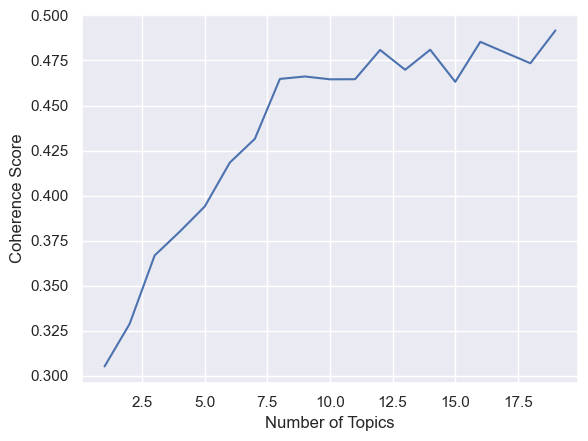

In [21]:
#Calculating the coherence score using C_v:
topics = []
score = []

for i in range(1,20,1):   
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 2, passes=10, random_state=100)   
    
    cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')   
    
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [22]:
# check  C_umass or C_v graphs for deciding number of topics
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=9, workers = 2, passes=100)

In [23]:
# printing out the (8) topics and related words; -1 orxered by significance
lda_model.print_topics(-1)

[(0,
  '0.051*"right" + 0.032*"agreement" + 0.030*"law" + 0.029*"human" + 0.028*"union" + 0.026*"eu" + 0.020*"country" + 0.016*"freedom" + 0.014*"rule" + 0.014*"international"'),
 (1,
  '0.024*"market" + 0.017*"company" + 0.015*"health" + 0.012*"product" + 0.012*"food" + 0.011*"sector" + 0.010*"regulation" + 0.010*"price" + 0.010*"consumer" + 0.010*"new"'),
 (2,
  '0.056*"member" + 0.044*"states" + 0.025*"commission" + 0.020*"eu" + 0.018*"committee" + 0.016*"report" + 0.014*"union" + 0.014*"parliament" + 0.010*"information" + 0.010*"national"'),
 (3,
  '0.027*"energy" + 0.021*"climate" + 0.019*"policy" + 0.016*"need" + 0.016*"development" + 0.015*"investment" + 0.014*"economic" + 0.013*"eu" + 0.012*"new" + 0.012*"support"'),
 (4,
  '0.036*"president" + 0.017*"want" + 0.015*"europe" + 0.013*"time" + 0.013*"colleague" + 0.012*"people" + 0.012*"today" + 0.012*"year" + 0.011*"think" + 0.011*"commissioner"'),
 (5,
  '0.057*"fund" + 0.056*"financial" + 0.053*"budget" + 0.027*"money" + 0.027*

In [31]:
lda_model.print_topic(6)

'0.040*"woman" + 0.030*"people" + 0.029*"social" + 0.028*"child" + 0.022*"young" + 0.020*"right" + 0.016*"work" + 0.014*"education" + 0.014*"violence" + 0.013*"health"'

In [32]:
df['text_translated'][10]

'The next point of the agenda is the choice of Vice President of the European Parliament.Candidates informed me that they were proposed with their agreement.Since the number of candidates exceeds the number of free seats, we have to carry out a secret election in accordance with the rules of procedure.Article 17 paragraph 1 of the rules of procedure apply.The vote is open.'

In [33]:
# the above text shall belong to the following topics:
lda_model[corpus][150]

[(3, 0.25064918), (4, 0.70207745), (7, 0.03787767)]

In [27]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

C:\Users\Katharina\anaconda3\envs\MA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [28]:
# add column to df with most probable topic
df['topic'] = [sorted(lda_model[corpus][text], key=itemgetter(1), reverse=True)[0][0] for text in range(len(df['text_translated']))]

In [29]:
# frequency of each topic:
df.topic.value_counts()

4    57491
1    31986
2    31459
3    30428
0    29481
8    27909
7    24076
5    18339
6    17422
Name: topic, dtype: int64

In [ ]:
# extract interventions where topics are women related

In [30]:
#df

In [34]:
df_women = df[df['topic'] == 6]
df_women

,int_id,debate_id,speaker,text,speaker_id,text_translated,tokens,topic
58,3-044-000,20140702.EN,João Ferreira,Ainda mal refeitas do enorme abanão que as úl...,96706,Still poorly referred to the huge abnanch that...,"[refer, huge, abnanch, election, represent, fo...",6
181,3-184-250,20140702.EN,Jutta Steinruck,schriftlich. – Die italienische Ratspräsident...,96831,in written form.- The Italian Presidency has s...,"[write, italian, presidency, set, good, priori...",6
227,1-057-000,20140714.EN,María Lidia Senra Rodríguez,"Señora Presidenta, decía que vengo de Galicia...",125049,"Mrs. President, said that I come from Galicia,...","[president, say, come, galicia, town, plurinat...",6
245,2-033-000,20140715.EN,Vilija Blinkevičiūtė,"raštu. – Pirmiausia norėčiau pabrėžti, jog vi...",96681,"in writing.- First of all, I would like to emp...","[like, emphasize, big, problem, european, unio...",6
250,2-036-000,20140715.EN,Jutta Steinruck,schriftlich. – Mit Blick auf das Arbeitsprogr...,96831,in written form.- With a view to the work prog...,"[write, view, work, program, future, commissio...",6
...,...,...,...,...,...,...,...,...
275040,3-311-0000,20220216.EN,Pierrette Herzberger-Fofana,"Monsieur le Président, Madame la Commissaire,...",197459,"Mr. President, Madam Commissioner, the Pandemi...","[president, madam, commissioner, pandemic, pre...",6
275042,3-313-0000,20220216.EN,Lina Gálvez Muñoz,"Señor presidente, señora comisaria, según las...",197702,"Mr. President, Mrs. Commissioner, according to...","[president, commissioner, accord, united, nati...",6
275043,3-314-0000,20220216.EN,Alessandra Moretti,"Signor Presidente, onorevoli colleghi, signor...",124799,"Mr. President, honorable colleagues, lady comm...","[president, honorable, colleague, lady, commis...",6
275044,3-315-0000,20220216.EN,Maria-Manuel Leitão-Marques,"Senhor Presidente, Senhora Comissária, não há...",197635,"Mr. President, Madam Commissioner, there is no...","[president, madam, commissioner, single, count...",6


In [35]:
df_women.iloc[1200]['text_translated']

'The situation of European women on the labour market is characterized by systemic discrimination. This is reflected in lower income, lack of representation at the highest levels of the career ladder and concentration in the less prestigious and less profitable sectors of the economy. Particularly vulnerable are women of childbearing age. Available settings in the field of education, in fact, reproduce the gender imbalance in the labour market. The issue of gender equality in the EU received public and Member States’ recognition, although the measures taken so far have not led to a radical change in the status of women on the labour market and to achieving substantive (rather than formal) equality between men and women in employment, in political and social life.'

In [36]:
date=df_women.debate_id.str.extract('(^\d*)')
df_women.insert (2, "date", date)
df_women['date'] = pd.to_datetime(df_women['date'], format='%Y%m%d')

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
C:\Users\Katharina\AppData\Local\Temp\ipykernel_9576\456753954.py:1: DeprecationWarning: invalid escape sequence \d
  date=df_women.debate_id.str.extract('(^\d*)')
C:\Users\Katharina\AppData\Local\Temp\ipykernel_9576\456753954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_women['date'] = pd.to_datetime(df_women['date'], format='%Y%m%d')


In [37]:
df_women = df_women.assign(YYYY = df_women.date)
df_women['YYYY'] = df_women.YYYY.dt.strftime('%Y')

In [38]:
df_women

,int_id,debate_id,date,speaker,text,speaker_id,text_translated,tokens,topic,YYYY
58,3-044-000,20140702.EN,2014-07-02,João Ferreira,Ainda mal refeitas do enorme abanão que as úl...,96706,Still poorly referred to the huge abnanch that...,"[refer, huge, abnanch, election, represent, fo...",6,2014
181,3-184-250,20140702.EN,2014-07-02,Jutta Steinruck,schriftlich. – Die italienische Ratspräsident...,96831,in written form.- The Italian Presidency has s...,"[write, italian, presidency, set, good, priori...",6,2014
227,1-057-000,20140714.EN,2014-07-14,María Lidia Senra Rodríguez,"Señora Presidenta, decía que vengo de Galicia...",125049,"Mrs. President, said that I come from Galicia,...","[president, say, come, galicia, town, plurinat...",6,2014
245,2-033-000,20140715.EN,2014-07-15,Vilija Blinkevičiūtė,"raštu. – Pirmiausia norėčiau pabrėžti, jog vi...",96681,"in writing.- First of all, I would like to emp...","[like, emphasize, big, problem, european, unio...",6,2014
250,2-036-000,20140715.EN,2014-07-15,Jutta Steinruck,schriftlich. – Mit Blick auf das Arbeitsprogr...,96831,in written form.- With a view to the work prog...,"[write, view, work, program, future, commissio...",6,2014
...,...,...,...,...,...,...,...,...,...,...
275040,3-311-0000,20220216.EN,2022-02-16,Pierrette Herzberger-Fofana,"Monsieur le Président, Madame la Commissaire,...",197459,"Mr. President, Madam Commissioner, the Pandemi...","[president, madam, commissioner, pandemic, pre...",6,2022
275042,3-313-0000,20220216.EN,2022-02-16,Lina Gálvez Muñoz,"Señor presidente, señora comisaria, según las...",197702,"Mr. President, Mrs. Commissioner, according to...","[president, commissioner, accord, united, nati...",6,2022
275043,3-314-0000,20220216.EN,2022-02-16,Alessandra Moretti,"Signor Presidente, onorevoli colleghi, signor...",124799,"Mr. President, honorable colleagues, lady comm...","[president, honorable, colleague, lady, commis...",6,2022
275044,3-315-0000,20220216.EN,2022-02-16,Maria-Manuel Leitão-Marques,"Senhor Presidente, Senhora Comissária, não há...",197635,"Mr. President, Madam Commissioner, there is no...","[president, madam, commissioner, single, count...",6,2022


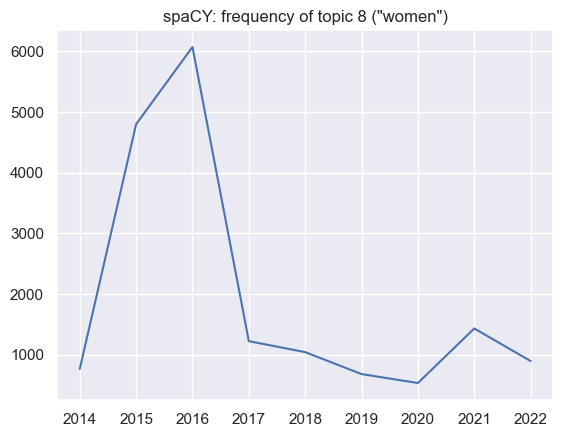

In [43]:
#df_women_grouped = df_women[df_women['YYYY'] > '2016']
df_women_grouped = df_women.groupby(["YYYY"]).size()
df_women_grouped.plot(xlabel='', ylabel = 'topic frequency') #hiding x-axis label
plt.title('spaCY: frequency of topic 8 ("women")')
plt.savefig('C:/Users/Katharina/Documents/Uni/6_WS2223/Masterarbeit/code/WomenInEP/plots/women-topics_2w_ints_new.png')